## 1. Agricultural Commodity Loss - Wheat and Drought

## Demo Overview: Overview of the problem, and summary of datasets

### Food Resilience NOAA key points (adapted from Third National Climate Assessment - Hatfield, et al, 2014)


 - Climate disruptions to agricultural production have increased over the past 40 years and are projected to increase over the next 25 years. Farmers and ranchers will likely need to increase their rate of innovation and adaptation to keep pace with this projected change.
 
 - Crop and livestock production in many agricultural regions will likely decline due to weeds, diseases, insects, and climate-related stresses.
 
 - The rising incidence of extreme weather—including heat waves, drought, and very heavy precipitation—will increasingly impact crop and livestock productivity.
 
 - Climate-related changes in crop yields and food prices as well as impacts on food processing, storage, and distribution systems can impact food security.
 
 
 ### Problem question: can we predict wheat - drought based commodity loss using climate related weather variables?
 
 

## Datasets and data sources used as part of the analysis

To be straightforward for the sake of demonstration - we are using two core datasets:
    
- **University of Idaho GRIDMET data.**  Since our CIRC project uses UIdaho GRIDMET/MACA data for a portion of our research efforts, i thought using this as an input dataset might be appropriate.  As a note, we can easily add variables to this grouping that might be from other sources.
- **USDA Economic Crop Loss data.**  The USDA's Risk Management Agency summarizes economic crop loss insurance claims at a county and monthly level, going back to 1980.  This dataset gives a historical view of crop loss, and to a more generalized degree, overall economic food security.  

Transforming both datasets to be spatially and geographically normalized (at the county/monthly/commodity level), we can then integrate into one big matrix.

## Loading libraries and importing data.  

This dataset is a ~14000 record dataset of monthly crop loss and acreage values, that has been integrated with GRIDMET daily data - summarized to monthly, and at a county geographic scale - for only Washington.

In [344]:
import PIL
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import os,sys
import numpy as np
from PIL import Image
from urllib2 import urlopen
import os,sys
from PIL import Image
import ipykernel
from sklearn import preprocessing
import pandas
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob


## Load Wheat annual summary data with climate already associated

In [347]:
os.chdir("/dmine/data/USDA/agmesh-scenarios/palouse/summaries/annual_county_summaries/")
#os.chdir("/agmesh-scenarios/scenario_52177/commodity_county/")
train = pd.read_csv('WHEAT_drought_summary', index_col=0)
%matplotlib nbagg

## Initially Loaded dataset - all wheat insurance claims in the Palouse region, that are attributed to drought as a damage cause, from 2007-2015

In [348]:
train_countratio = train

## Dataset with no zero loss values

In [349]:
train_countratio_nona = train[np.isfinite(train['countratio'])]

In [350]:
train_countratio = train_countratio.loc[train_countratio.countratio != 0]

## Subsetting to review Whitman county data

In [351]:

train_whitman = train.loc[train['county'] == 'Whitman']

In [352]:
train_whitman

,X,bi,pr,th,pdsi,pet,erc,rmin,rmax,tmmn,...,vs,fm1000,fm100,loss,acres,count,year,county,countratio,prpet
226,2007,16.962192,1.187937,194.518542,-0.327727,2.720757,23.802154,46.672839,87.556913,274.498554,...,3.532706,19.446807,16.336210,689131.40,15671.6820,8,2007,Whitman,0.044199,-1.532820
227,2008,13.248623,1.535897,201.417912,-1.554576,2.047653,19.564753,49.146080,89.928847,272.980393,...,3.762149,20.207536,17.840559,4978960.03,68318.0752,13,2008,Whitman,0.050193,-0.511756
228,2009,15.100469,1.775636,189.204528,0.169830,2.171742,21.432374,47.008629,87.575773,273.153835,...,3.467074,20.097073,17.293578,4866938.96,25053.1323,12,2009,Whitman,0.050847,-0.396105
229,2010,18.032933,1.389417,185.815483,-1.310444,2.087974,24.770339,46.163165,86.698961,273.790608,...,3.656557,18.457042,16.574641,800627.44,16726.5304,13,2010,Whitman,0.106557,-0.698557
230,2011,12.093278,1.955923,-68.238296,-0.285239,1.866133,15.364309,51.779750,91.354612,272.800157,...,3.841298,21.721578,18.634729,131156.50,1431.0900,2,2011,Whitman,0.133333,0.089790
231,2012,15.952314,1.924354,198.650380,0.711248,1.976146,19.552676,49.388594,88.751240,273.478963,...,3.924238,20.199713,17.759726,3211.00,97.9000,1,2012,Whitman,0.013333,-0.051792
232,2013,18.556979,1.618273,17.184071,1.176068,2.147047,24.046774,47.841867,86.822439,274.413749,...,3.615147,19.101970,17.032024,473468.51,6511.7939,6,2013,Whitman,0.035088,-0.528774
233,2014,17.135539,1.371330,-548.908429,-1.097229,2.109510,22.830786,48.630845,86.889150,273.322329,...,3.523987,19.477797,17.008711,10985352.45,139687.8511,16,2014,Whitman,0.062257,-0.738180
234,2015,19.808093,1.509605,174.115537,-2.183060,2.432261,26.480061,44.725920,84.729778,275.523826,...,3.312283,18.739996,16.247399,15040222.21,181707.6696,16,2015,Whitman,0.059480,-0.922656


In [354]:
train['logloss'] = log(train.loss)
#train.logloss = filter(lambda a: a != -inf, train.logloss)

<IPython.core.display.Javascript object>


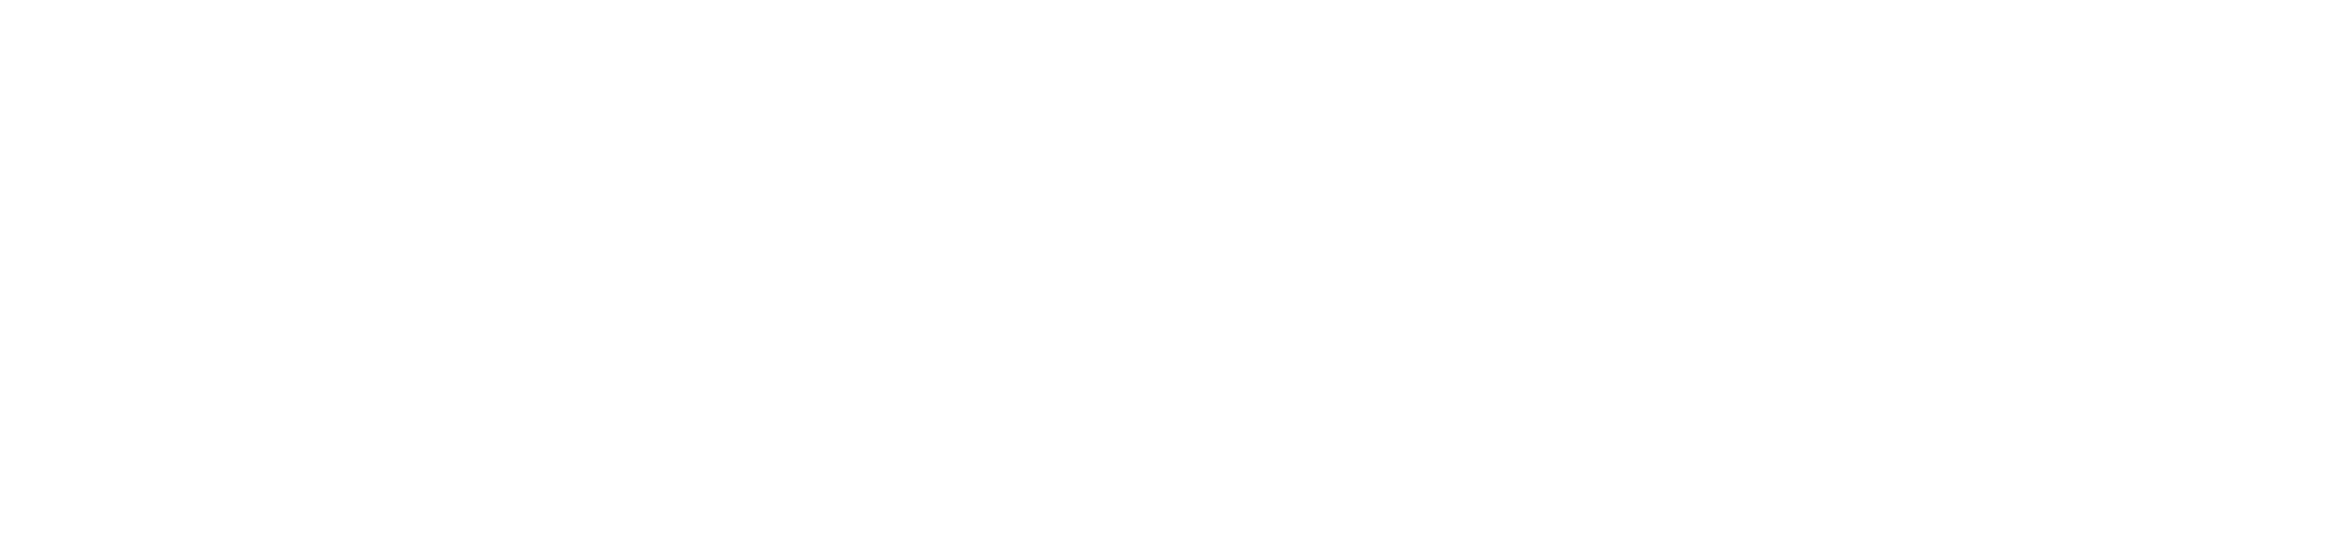

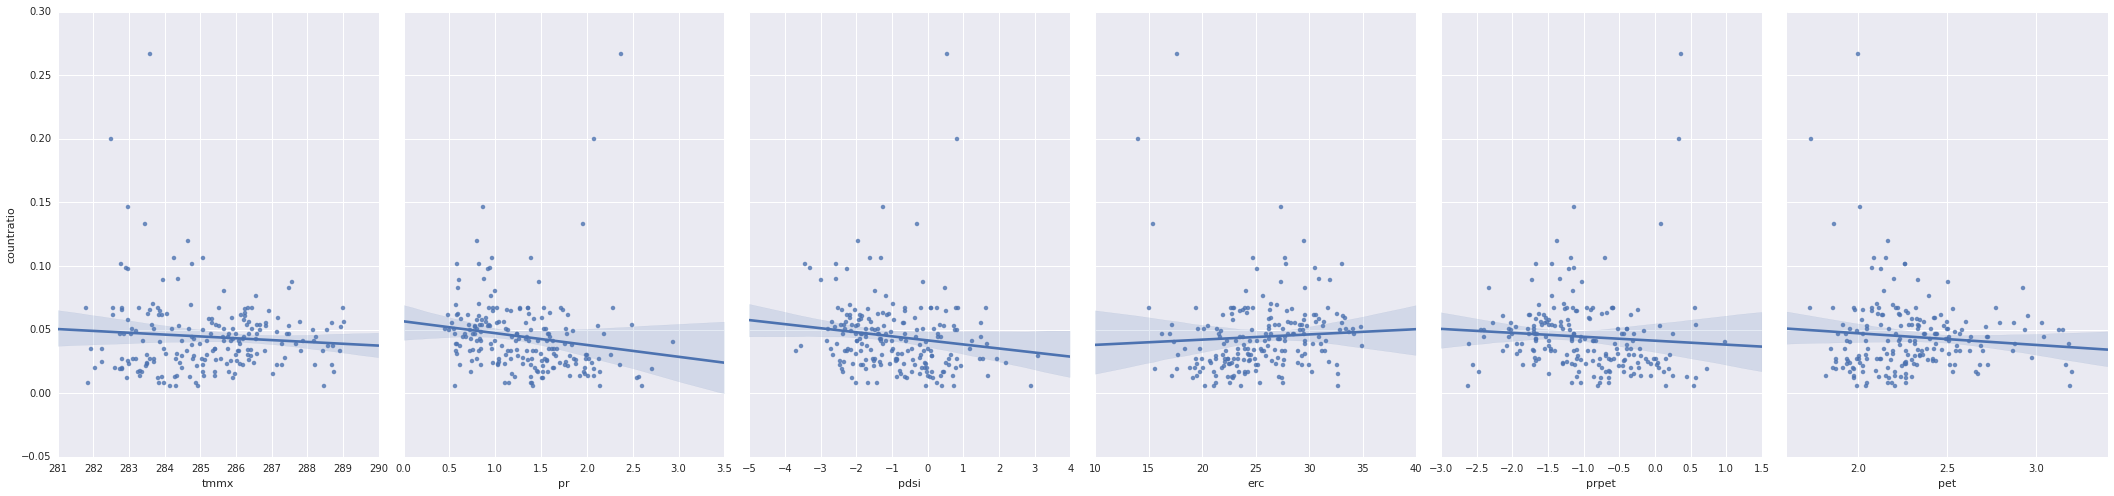

In [325]:
import seaborn as sns
sns.pairplot(train_countratio, x_vars=['tmmx','pr','pdsi', 'erc', 'prpet', 'pet'], y_vars='countratio', size=7, aspect=0.7, kind='reg')


<IPython.core.display.Javascript object>


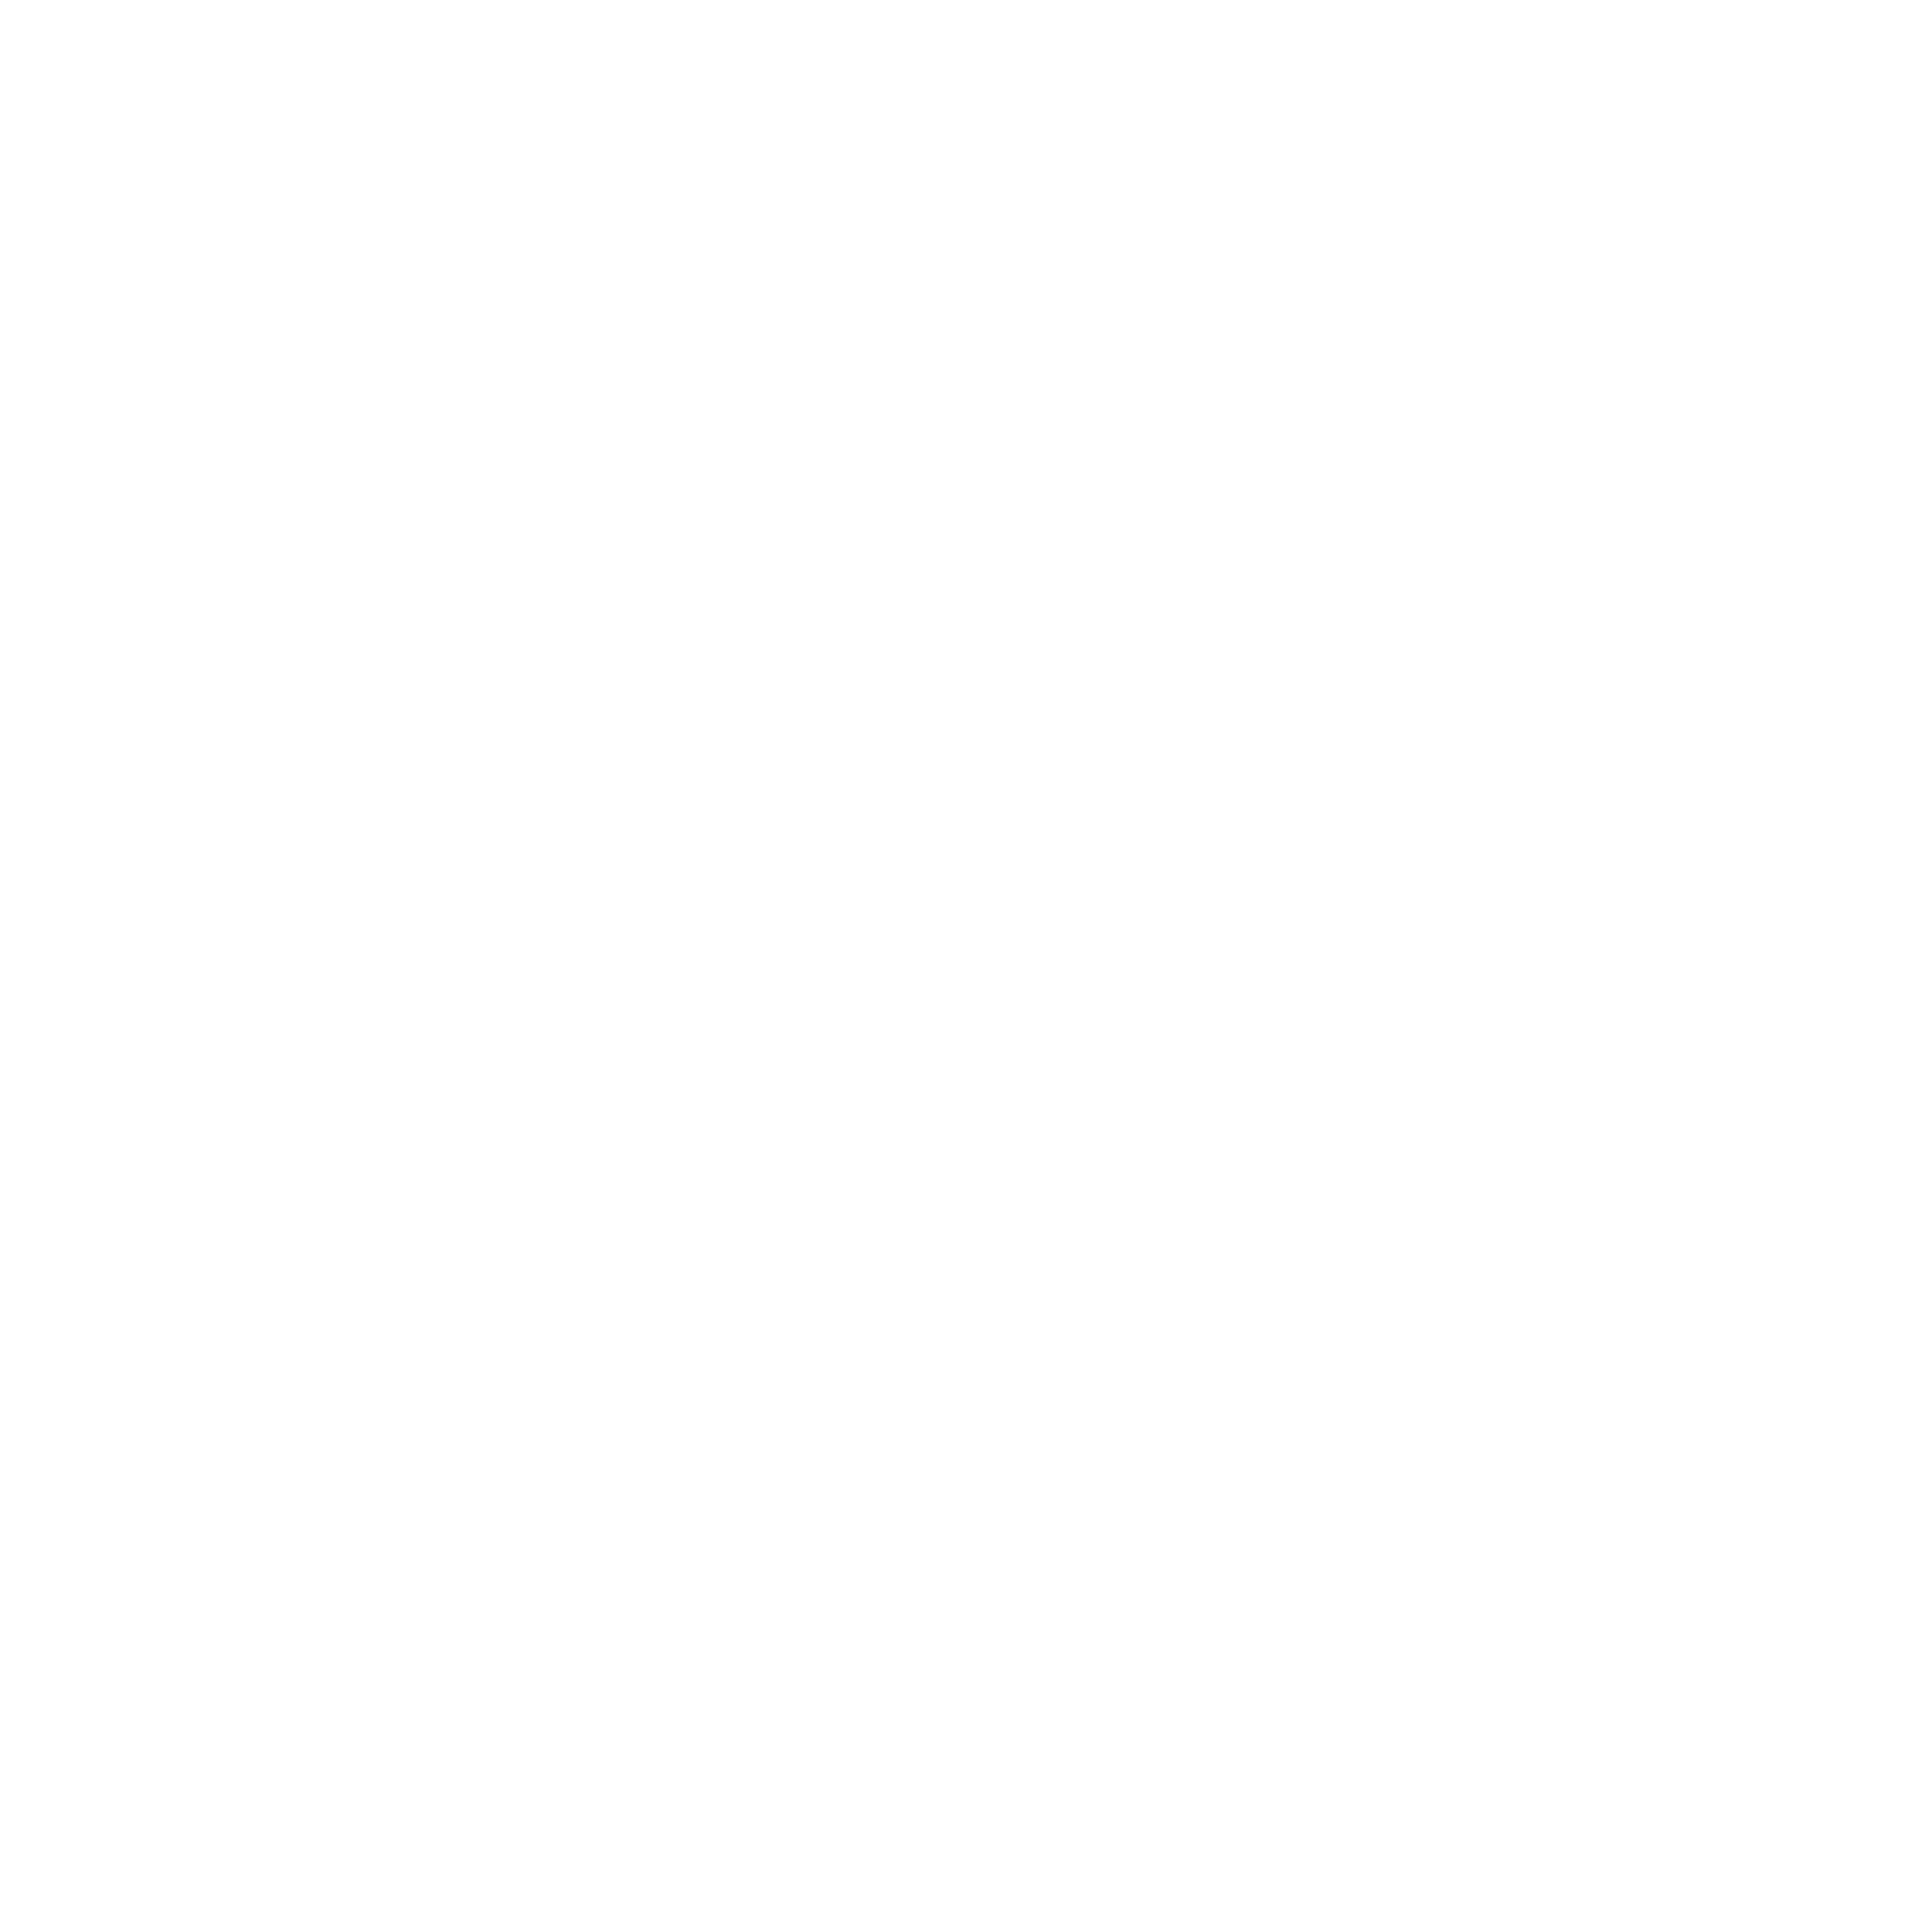

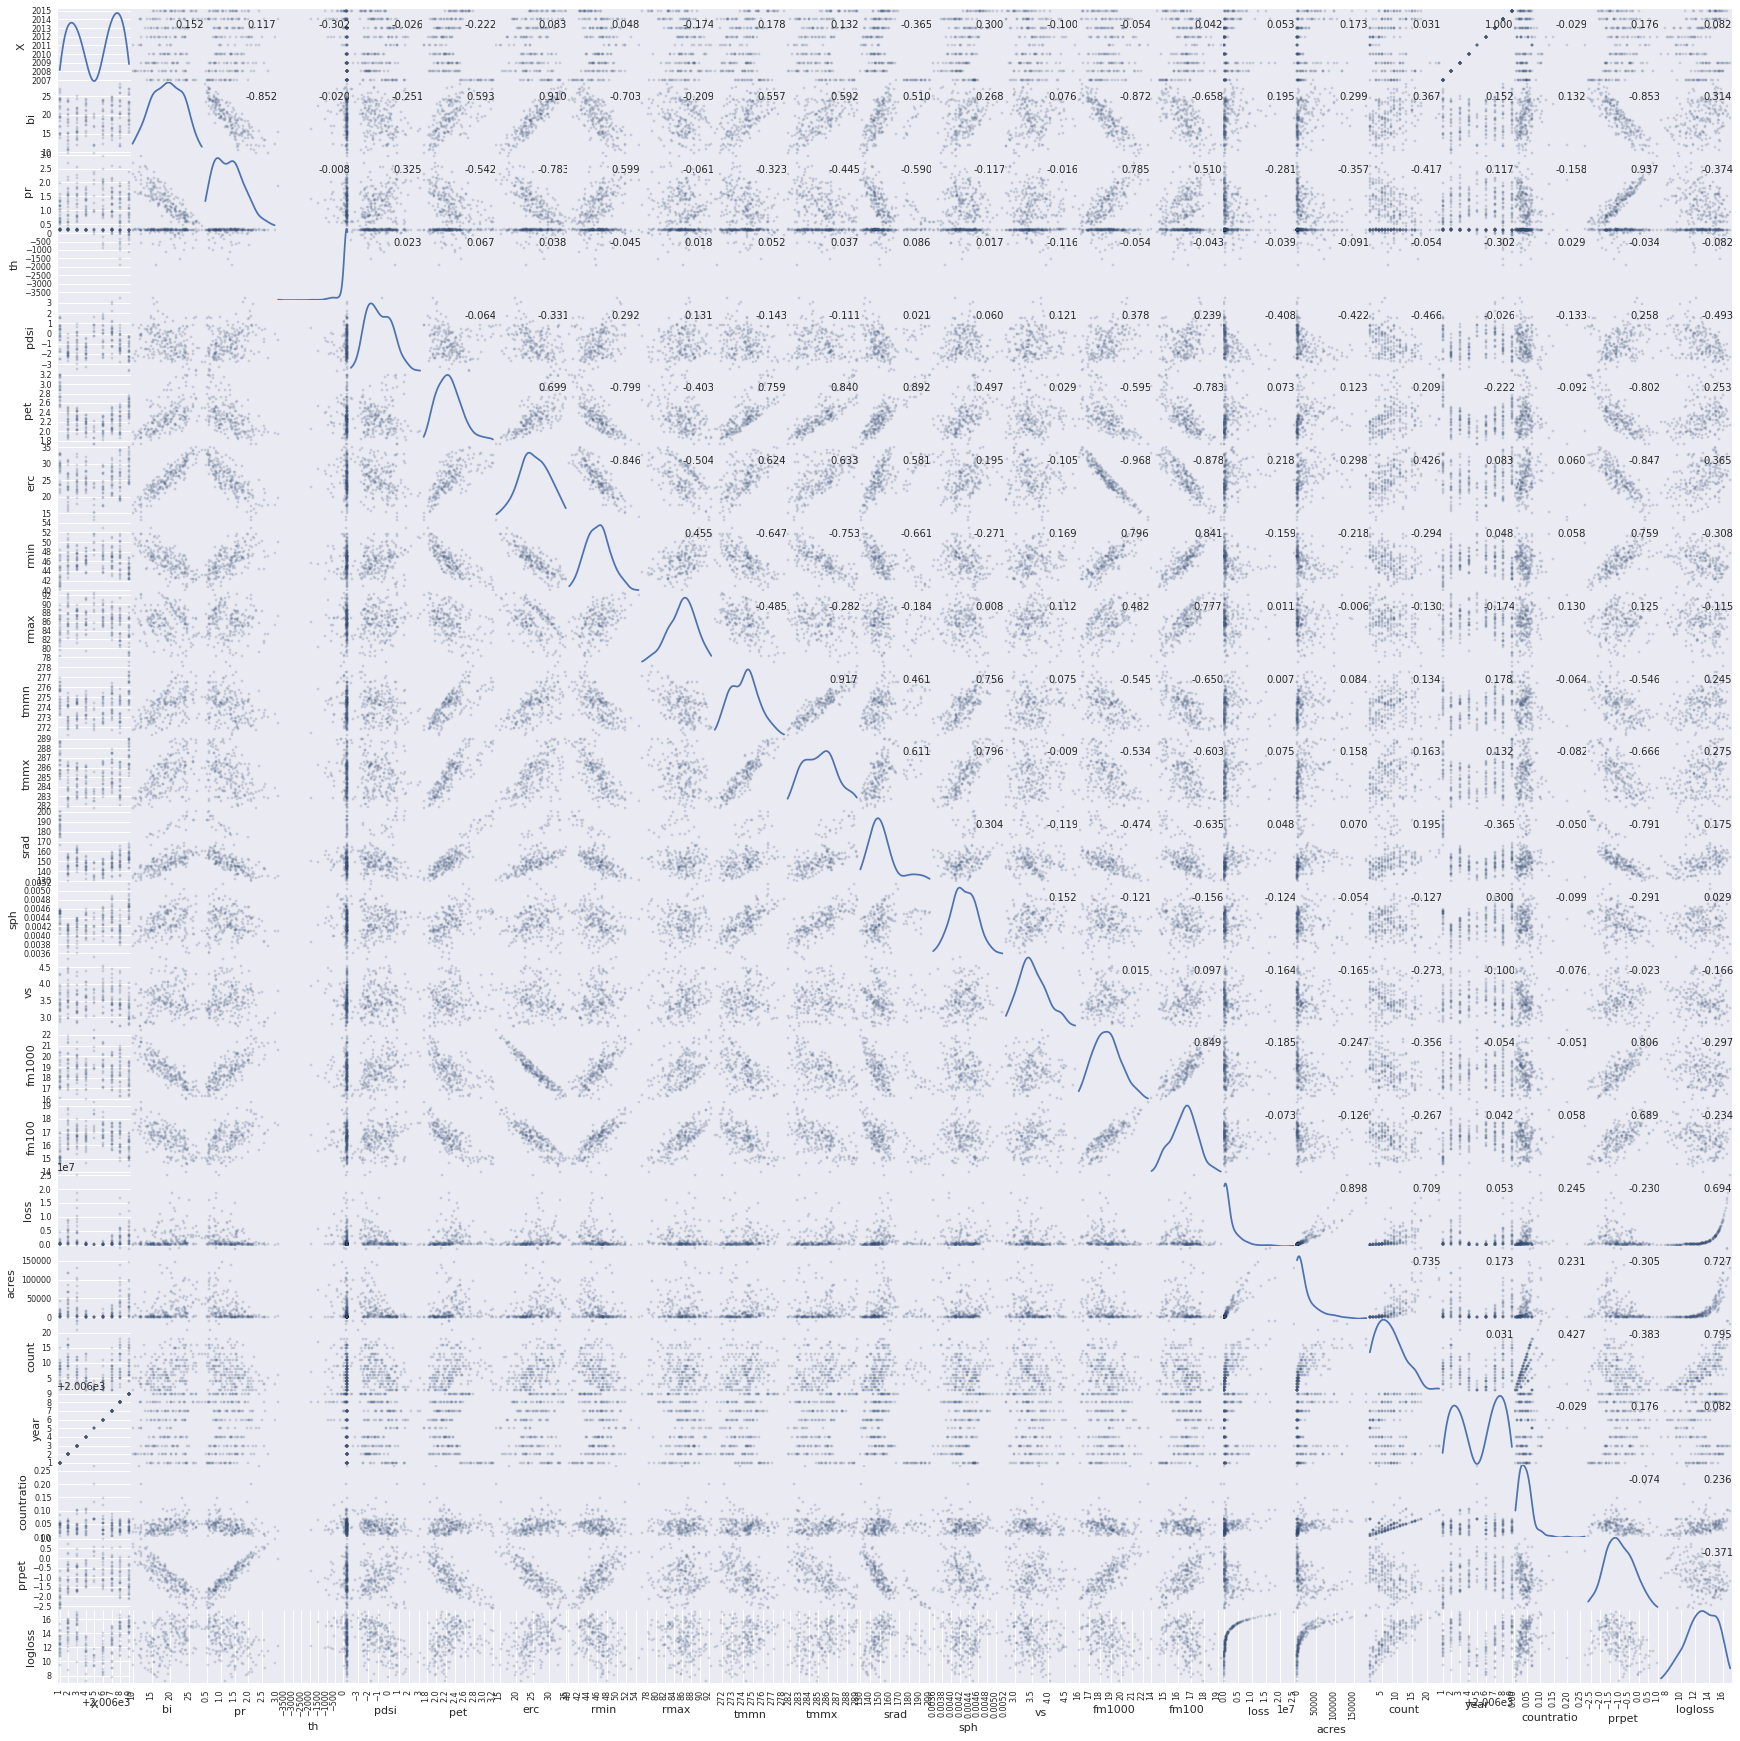

In [312]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(train_countratio, alpha=0.2, figsize=(30, 30), diagonal='kde')
corr = train_countratio.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

## Normalize and scale data

In [355]:
# create column vectors
# all columns
all_cols = ['bi', 'pr', 'th', 'pdsi', 'pet', 'erc', 'tmmx', 'tmmn', 'rmin', 'rmax', 'sph', 'srad', 'vs', 'fm1000', 'fm100', 'loss', 'acres', 'county', 'year']

#all_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'acres', 'countyfips', 'year', 'monthcode',  'damagecausecode', 'insuranceplancode', 'commoditycode', 'stagecode', 'loss']

# only feature columns
feature_cols1 = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'countyfips', 'year', 'monthcode',  'damagecausecode', 'insuranceplancode', 'commoditycode', 'stagecode', 'acres', 'loss']

feature_cols = ['bi', 'pr', 'th', 'pdsi', 'pet', 'erc', 'tmmx', 'tmmn', 'rmin', 'rmax', 'sph', 'srad', 'vs', 'fm1000', 'fm100']

matrix_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'loss']
matrix_withlog_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'loss', 'logloss']

matrix_less_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax']
all_minus_cols = ['loss', 'acres', 'county', 'year']

#--------

# Creating X for machine learning for joining with dummy fields

X_climate = train[feature_cols]
Xpre = stats.zscore(X_climate)
Xpre = pd.DataFrame(X_climate)
X1 = train[all_minus_cols]
X1 = pd.DataFrame(X1)
X = pd.concat([Xpre, X1], axis=1)

# create dummy code columns

monthcode_dummies = pd.get_dummies(X['county'])
damagecause_dummies = pd.get_dummies(X['year'])
#insuranceplancode_dummies = pd.get_dummies(X['insuranceplancode'])
#commodity_dummies = pd.get_dummies(X['commoditycode'])
#stagecode_dummies = pd.get_dummies(X['stagecode'])
#countyfips_dummies = pd.get_dummies(X['countyfips'])
#year_dummies = pd.get_dummies(X['year'])


In [327]:
#-generate zscores for all the x climate data variables.  Adds a '_zscore' to the end of the column name

for col in Xpre:
    col_zscore = col + '_zscore'
    Xpre[col_zscore] = (Xpre[col] - Xpre[col].mean())/Xpre[col].std(ddof=0)


In [328]:
Xpre_standard = Xpre.ix[:,15:]


In [329]:
Xpre_standard

,bi_zscore,pr_zscore,th_zscore,pdsi_zscore,pet_zscore,erc_zscore,tmmx_zscore,tmmn_zscore,rmin_zscore,rmax_zscore,sph_zscore,srad_zscore,vs_zscore,fm1000_zscore,fm100_zscore
1,0.858373,-1.418022,0.228565,0.946017,2.147029,1.042313,1.405884,0.653811,-1.449307,0.332502,0.275005,2.733495,-1.360282,-0.631910,-1.053730
2,0.393636,-1.445501,0.245479,-1.085056,-0.220093,0.497380,-0.160693,-0.704567,-0.274596,1.159077,-1.156539,0.043222,-1.075999,-0.595082,0.298142
3,0.411764,-1.008005,0.218525,-1.390981,-0.000096,0.673525,-0.138812,-0.603356,-0.607865,0.386465,-1.206699,0.449600,-1.568738,-0.643579,-0.137241
4,0.588670,-0.734915,0.203932,-0.653163,-0.360600,0.647817,0.025431,-0.028443,-0.978797,0.545461,-0.362470,-0.236622,-1.182969,-0.721589,-0.229085
5,-0.118299,-0.610526,0.009820,1.507538,-0.777553,-0.586187,-0.352230,-0.805883,0.709565,1.702349,0.050612,-0.321007,-0.715057,0.526605,1.069289
6,0.703453,-0.808258,0.228547,-0.915669,-0.444073,0.524436,0.244382,-0.425136,-0.760996,0.690223,-0.234014,-0.358434,-0.605526,-0.788790,-0.079095
7,0.944369,-0.731635,0.276694,0.523811,-0.000702,0.902771,0.846600,0.336584,-0.744459,0.276658,0.482967,0.092807,-1.162358,-0.807235,-0.195514
8,1.251152,-1.342420,0.175922,-0.668761,0.119703,1.301716,0.184374,-0.468266,-1.147484,-0.212803,-1.228745,0.188197,-1.154778,-1.154687,-0.782918
9,1.164110,-0.870409,0.222564,-1.162351,0.753830,1.395258,1.579189,1.085283,-1.360170,-0.519504,0.891016,0.491531,-1.862566,-0.979741,-0.817663
10,1.332759,-0.997333,0.360461,-0.822595,2.246118,1.775431,0.702466,1.274794,-0.701884,-2.451965,0.409648,2.064128,1.559251,-1.922935,-2.560242


## Rename dummy variables

In [330]:
monthcode_dummies = monthcode_dummies.rename(columns={1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec', '11': 'nov'})
damagecause_dummies = damagecause_dummies.rename(columns={'11': 'drought', '12': 'heat', '43': 'cold winter', '21': 'hail', '41': 'frost', '1': 'decline in price', '81': 'plant disease', '42': 'freeze', '31': 'excess moisture/precip/rain', '51': 'flood', '61': 'wind/excess wind', '71': 'insects', '44': 'cold wet weather', '91': 'fire', '13': 'failure irrig supply', '99': 'other(snow-lightning-etc)', '01': 'decline in price', '93': 'wildlife', '63': 'cyclone', '87': 'falling numbers', '14': 'failure irrig equip', 'XX': 'other causes', '62': 'hot wind'})
#insuranceplancode_dummies = insuranceplancode_dummies.rename(columns={44: 'CRC', 42: 'IP', 90: 'APH', 1: 'YP', 2: 'RP', 3: 'RPHPE'})


In [331]:
# Put the dummy code data together

dummies = pd.concat([monthcode_dummies, damagecause_dummies], axis=1)

In [332]:
#  merge dummies with X

Xm_standard = pd.concat([Xpre_standard], axis=1)
#Xm_standard = pd.DataFrame(stats.zscore(Xm))

# ***** Xm_standard becomes the final X response vector for our machine learning model *****

# create response vector (y)

y = train.loss
y = pd.Series.to_frame(y)

y_count = train.countratio
y_count = pd.Series.to_frame(y_count)
y_regular_count = train.count
#y_regular_count = pd.Series.to_frame(y_regular_count)


#y = stats.zscore(y)
#y = np.ravel(y)

#-log transform crop loss data for boxplot

ylog = np.log(y)
ylog.columns = ['logloss']

# create standardized dataset
standardized = pd.concat([X, y], axis=1)
standardized_withlog = pd.concat([X, y, ylog], axis=1)
#standardized_withlog.columns = matrix_withlog_cols
#standardized.columns = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'acres', 'countyfips', 'year', 'monthcode',  'damagecausecode', 'insuranceplancode', 'commoditycode', 'stagecode', 'loss']


# actual dataset, not normalized
actual = pd.concat([train[feature_cols], train[all_minus_cols], y],  axis=1)
actual_count = pd.concat([train[feature_cols], train[all_minus_cols], y_count],  axis=1)
#actual.columns = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'acres', 'countyfips', 'year', 'monthcode',  'damagecausecode', 'insuranceplancode', 'commoditycode', 'stagecode', 'loss']
actual_log = pd.concat([actual, ylog],  axis=1)

In [333]:
train.count


<bound method DataFrame.count of         X         bi        pr           th      pdsi       pet        erc  \
1    2007  22.257944  0.590157   179.716284  0.486312  2.924690  29.660450   
2    2008  20.268424  0.574885   186.179884 -2.179470  2.197480  27.031190   
3    2009  20.346031  0.818023   175.879772 -2.580997  2.265066  27.881075   
4    2010  21.103356  0.969793   170.303043 -1.612611  2.154315  27.757036   
5    2011  18.076855  1.038922    96.125705  1.223308  2.026221  21.803058   
6    2012  21.594737  0.929032   179.709281 -1.957150  2.128671  27.161732   
7    2013  22.626085  0.971615   198.108415 -0.067833  2.264880  28.987169   
8    2014  23.939410  0.632172   159.599634 -1.633083  2.301870  30.912051   
9    2015  23.566787  0.894492   177.423081 -2.280920  2.496682  31.363380   
10   2007  24.288767  0.823954   230.118737 -1.834990  2.955132  33.197691   
11   2008  18.808378  1.103171   235.612136 -2.087995  2.263788  26.946243   
12   2009  20.567395  1.213905 

## Loss and count datasets combined

In [334]:
# actual dataset, not normalized
actual = pd.concat([train[feature_cols], train[all_minus_cols], y],  axis=1)
actual_count = pd.concat([train[feature_cols], train[all_minus_cols], y_count],  axis=1)
#actual.columns = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'acres', 'countyfips', 'year', 'monthcode',  'damagecausecode', 'insuranceplancode', 'commoditycode', 'stagecode', 'loss']
actual_log = pd.concat([actual, ylog],  axis=1)

## Generate zscores for all the x climate data variables.  Adds a '_zscore' to the end of the column name

In [335]:
#-generate zscores for all the x climate data variables.  Adds a '_zscore' to the end of the column name

for col in y:
    col_zscore = col + '_zscore'
    y[col_zscore] = (y[col] - y[col].mean())/y[col].std(ddof=0)

## Standardize Y for Loss

In [336]:
y_standard = y['loss']
y_zscore = y['loss_zscore']
y = y_standard

In [337]:
y_standard_count = y_count['countratio']

### Normalize Y

In [338]:
# convert y series to a data frame

y_zscore = pd.Series.to_frame(y_zscore)

### List y columns 

In [339]:
y_zscore.columns.unique()

array(['loss_zscore'], dtype=object)

### List X normalized columns

In [340]:
dummies.columns

Index([      u'Adams',      u'Asotin',     u'Benewah',      u'Benton',
        u'Clearwater',    u'Columbia',     u'Douglas',    u'Franklin',
          u'Garfield',     u'Gilliam',       u'Grant',       u'Idaho',
          u'Kootenai',       u'Latah',       u'Lewis',     u'Lincoln',
            u'Morrow',   u'Nez Perce',     u'Sherman',     u'Spokane',
          u'Umatilla',       u'Union', u'Walla Walla',     u'Wallowa',
             u'Wasco',     u'Whitman',           2007,           2008,
                 2009,           2010,           2011,           2012,
                 2013,           2014,           2015],
      dtype='object')

# Exploratory Data Analysis

In [341]:
# Put Xm_standard and y_zscore together, for EDA
train_EDA = pd.concat([Xm_standard, y_zscore],  axis=1)
train_EDA_count = pd.concat([Xm_standard, y_standard_count], axis=1)

In [ ]:
from pandas.tools.plotting import scatter_matrix

axes = scatter_matrix(train_EDA_count, alpha=0.2, figsize=(30, 30), diagonal='kde')
corr = train_countratio.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

<IPython.core.display.Javascript object>

## All Wheat Loss by Year for Washington, 2007-2015

In [ ]:
%matplotlib nbagg

train.groupby(['year']).loss.sum().plot(kind='bar')
plt.ylabel('Crop Loss (Billions of $)', fontsize=16)


## All Loss by Commodity for Counties, 2007-2015

<IPython.core.display.Javascript object>


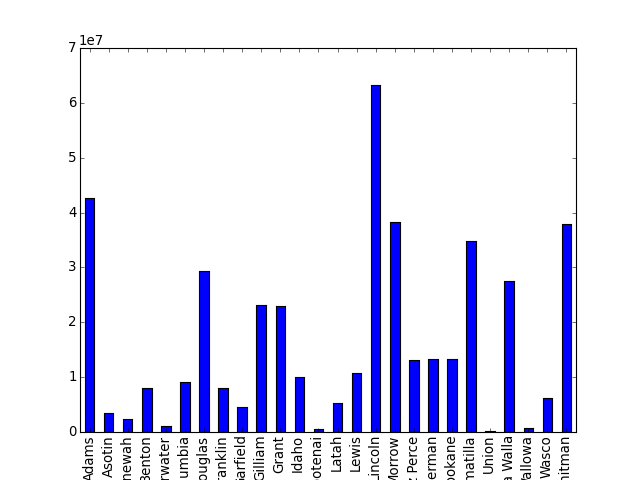

In [29]:
%matplotlib nbagg
train.groupby(['county']).loss.sum().plot(kind='bar')

## Histogram of loss by County, Washington, 2007 - 2015.  Are there many small claims, a few large claims by county?

In [239]:
%matplotlib inline
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

actual_count.hist(column='count', grid=False, bins=50)


KeyError: "['count'] not in index"

In [231]:
y_count_centered


,countratio
0,1.377080
1,0.962361
2,1.960700
3,2.111472
4,-1.192591
5,0.461135
6,-0.467272
7,0.617177
8,0.536444
9,0.691834


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06333dd290>]], dtype=object)

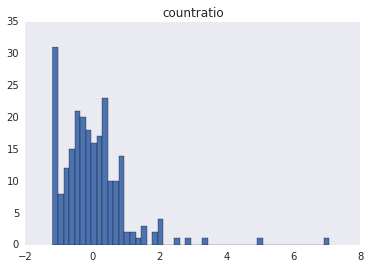

In [229]:

y_count = y_count[np.isfinite(y_count['countratio'])]

y_count_centered = preprocessing.scale(y_count, with_mean='True', with_std='False')
y_count_centered = pandas.DataFrame(y_count_centered)
y_count_centered
y_count_centered.columns = ['countratio']

#y_count_centered_df = pd.DataFrame(y_count_centered, columns=h2.columns)
%matplotlib inline
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')



y_count_centered.hist(column='countratio', grid=False, bins=50)

## Box Plot of Wheat crop loss by month, Washington, 2007 - 2015 - by year - using log tranformed data

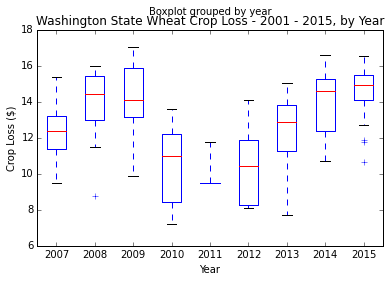

In [83]:
%matplotlib inline

from pylab import *
from scipy.io import loadmat

actual_log.boxplot(column='logloss', by='year', grid=False)
# labels = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
# xticks(range(1,13),labels, rotation=15)
xlabel('Year')
ylabel('Crop Loss ($)')
title('Washington State Wheat Crop Loss - 2001 - 2015, by Year')

## Box Plot of Wheat crop loss by damage cause, Washington, 2001 - 2015 - by year - using log tranformed data

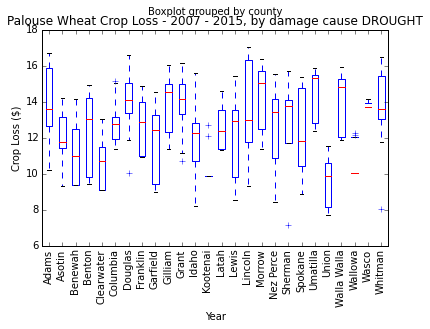

In [84]:
%matplotlib inline

from pylab import *
from scipy.io import loadmat

actual_log.boxplot(column='logloss', by='county', grid=False, rot=90)
# labels = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
# xticks(range(1,13),labels, rotation=15)
xlabel('Year')
ylabel('Crop Loss ($)')
title('Palouse Wheat Crop Loss - 2007 - 2015, by damage cause DROUGHT')

## Setup Training and Testing
### Xm_standard - X vector, normalized
### y_zscore - y vector, normalized

In [86]:
Xm_standard = Xm_standard.drop('loss_zscore', 1)
Xpre_standard = Xpre_standard.drop('loss_zscore', 1)

ValueError: labels ['loss_zscore'] not contained in axis

In [193]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xm_standard, y_zscore)

## Actual observations, Washington, 2001 - 2015, with no z score standardization

In [88]:
actual.head()

,bi,pr,th,pdsi,pet,erc,tmmx,tmmn,rmin,rmax,sph,srad,vs,fm1000,fm100,loss,acres,county,year,loss
0,22.257944,0.590157,179.716284,0.486312,2.924690,29.660450,287.486048,274.979516,42.589828,87.350024,0.004368,191.822666,2.985408,18.006201,15.559875,806957.68,17882.5445,Adams,2007,806957.68
1,20.268424,0.574885,186.179884,-2.179470,2.197480,27.031190,284.735873,273.083424,45.825838,90.034216,0.003968,151.906997,3.110257,18.058951,16.952437,8842715.41,117781.9306,Adams,2008,8842715.41
2,20.346031,0.818023,175.879772,-2.580997,2.265066,27.881075,284.774286,273.224700,44.907774,87.525261,0.003954,157.936440,2.893860,17.989488,16.503949,18434227.40,104871.7335,Adams,2009,18434227.40
3,21.103356,0.969793,170.303043,-1.612611,2.154315,27.757036,285.062619,274.027192,43.885957,88.041580,0.004190,147.754939,3.063279,17.877753,16.409341,313882.34,7791.5224,Adams,2010,313882.34
4,18.076855,1.038922,96.125705,1.223308,2.026221,21.803058,284.399623,272.942003,48.536935,91.798421,0.004305,146.502920,3.268772,19.665562,17.746794,0.00,0.0000,Adams,2011,0.00


## Observations, Washingtion, 2001 - 2015, with all climate data converted to z-scores

In [70]:
Xm_standard.columns

Index([u'bi_zscore', u'pr_zscore', u'th_zscore', u'pdsi_zscore', u'pet_zscore',
       u'erc_zscore', u'tmmx_zscore', u'tmmn_zscore', u'rmin_zscore',
       u'rmax_zscore', u'sph_zscore', u'srad_zscore', u'vs_zscore',
       u'fm1000_zscore', u'fm100_zscore'],
      dtype='object')

## Linear Regression

In [194]:

# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [195]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[-0.02282895]
[[ 0.14231691 -0.64948607  0.02316547 -0.29856519  1.68942294  0.09651888
   0.25509771 -0.6505751   0.01030991 -1.26824337 -0.13534647 -0.72404089
  -0.25695745 -0.35250427  2.40608004]]


In [196]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('bi', array([ 0.14231691, -0.64948607,  0.02316547, -0.29856519,  1.68942294,
          0.09651888,  0.25509771, -0.6505751 ,  0.01030991, -1.26824337,
         -0.13534647, -0.72404089, -0.25695745, -0.35250427,  2.40608004]))]

In [197]:
# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [198]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

1.05907554783


                            OLS Regression Results                            
Dep. Variable:            loss_zscore   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     10.61
Date:                Sat, 13 May 2017   Prob (F-statistic):           5.29e-19
Time:                        00:03:22   Log-Likelihood:                -267.91
No. Observations:                 234   AIC:                             567.8
Df Residuals:                     218   BIC:                             623.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          1.127e-14      0.051   2.19e-13

<IPython.core.display.Javascript object>


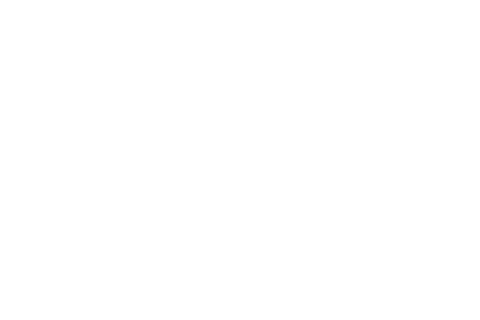

ValueError: x and y must be the same size

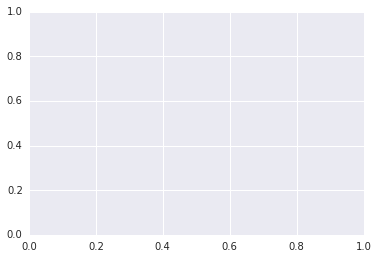

In [200]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt


results = sm.OLS(y,sm.add_constant(X)).fit()

print results.summary()

plt.scatter(X, y)

#X_plot = np.linspace(0,1,100)
#plt.plot(X_plot, X_plot*results.params[0] + results.params[1])

#plt.show()

# Machine Learning Analysis

### Remove acreage as a feature variable.  

In [217]:
X = Xm_standard
#y = y_standard
y = y_count

## Build a classification tree

In [ ]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
scores = cross_val_score(treeclf, X, y, cv=10, scoring='accuracy')
treeclf.fit(X, y)
print scores

In [343]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

model2 = ExtraTreesClassifier(random_state=42)
model = RandomForestClassifier(random_state=42)
model3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm="SAMME", n_estimators=200)
#model.fit(X,y)
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
scores2 = cross_val_score(model2, X, y, cv=10, scoring='accuracy')
scores3 = cross_val_score(model3, X, y, cv=10, scoring='accuracy')
model.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
print "R^2 model Random Forest Classifier:", model.score(X_test, y_test).round(2)
print "R^2 model Extra Trees Classifier:", model2.score(X_test, y_test).round(2)
print "R^2 model AdaBoost:", model3.score(X_test, y_test).round(2)

plot_colors = "br"





plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X(:, 0).min() - 1, X(:, 0).max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()





SyntaxError: invalid syntax (<ipython-input-343-a076c0991f81>, line 37)

## Building a regression decision tree in scikit-learn

In [218]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

In [219]:
# use 10 fold CV to estimate the RMSE for this model
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

0.043890796672313069

<IPython.core.display.Javascript object>


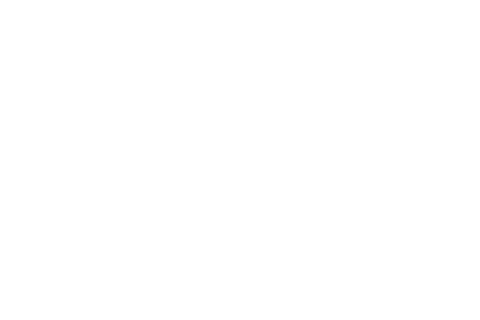

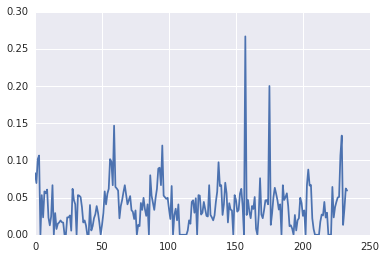

In [221]:
plot(y)

## Tuning regression tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [211]:
# try different values one-by-one
treereg = DecisionTreeRegressor(max_depth=10, random_state=1)
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

4117873.3929137476

## Looping thru a set number of max_depths to see the optimum level

In [214]:
# list of values to try
max_depth_range = range(1, 50)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
RMSE_scores

<IPython.core.display.Javascript object>


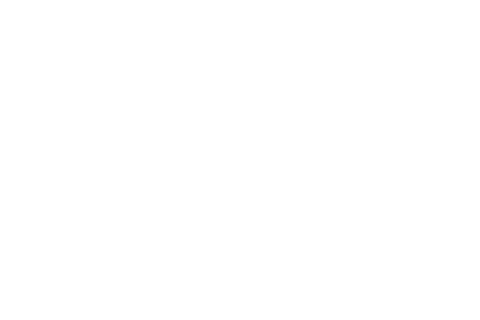

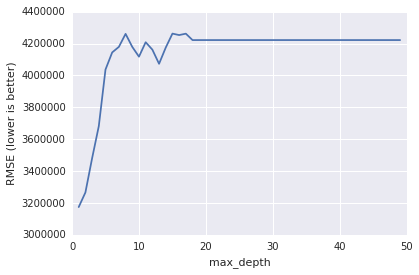

In [216]:
%matplotlib nbagg
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

#### NRMSE = RMSE/(max(DV)-min(DV)) 

In [127]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=10, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

## Decision Tree Feature Importance determination

In [128]:
cols = Xm_standard.columns

In [129]:
cols

Index([u'bi_zscore', u'pr_zscore', u'th_zscore', u'pdsi_zscore', u'pet_zscore',
       u'erc_zscore', u'tmmx_zscore', u'tmmn_zscore', u'rmin_zscore',
       u'rmax_zscore', u'sph_zscore', u'srad_zscore', u'vs_zscore',
       u'fm1000_zscore', u'fm100_zscore'],
      dtype='object')

In [130]:
pd.set_option('display.max_rows', 640)
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
importance = pd.DataFrame({'feature':cols, 'importance':treereg.feature_importances_})


In [131]:
importance

,feature,importance
0,bi_zscore,0.003257
1,pr_zscore,0.141465
2,th_zscore,0.074119
3,pdsi_zscore,0.018150
4,pet_zscore,0.038223
5,erc_zscore,0.267447
6,tmmx_zscore,0.131948
7,tmmn_zscore,0.015933
8,rmin_zscore,0.001438
9,rmax_zscore,0.012602


In [54]:
sig_feature_cols = ['pdsi_zscore', 'decline in price', 'srad']
X_sig = train[feature_cols]


## Creating a tree diagram

In [111]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='/home/git/dmine/circ/tree_ag.dot', feature_names=cols)
#export_graphviz(treereg, out_file='tree_ag.dot')

#print fileconvert
# At the command line, run this to convert to PNG:
#dot -Tpng tree_ag.dot -o tree_ag.png

In [56]:
%system("dot -Tpng /home/git/dmine/circ/tree_ag.dot -o /home/git/dmine/circ/tree_ag_wheat.png")

['/bin/sh: dot -Tpng /home/git/dmine/circ/tree_ag.dot -o /home/git/dmine/circ/tree_ag_wheat.png: No such file or directory']

In [ ]:

graph.draw('tree_ag_wheat.png')

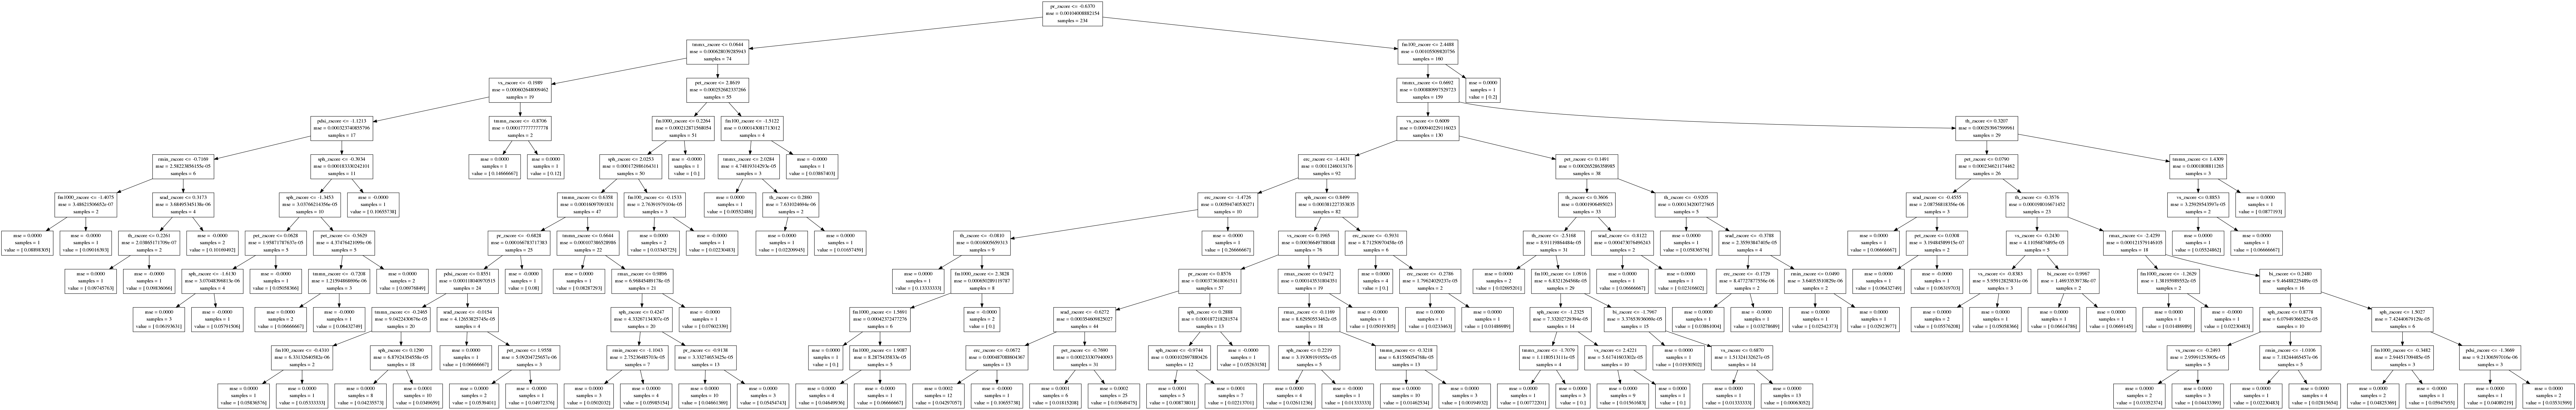

In [112]:
from IPython.display import Image
Image(filename='/home/git/dmine/circ/tree_ag_wheat.png')

## Making predictions for the testing data

**Question:** Using the tree diagram above, what predictions will the model make for each observation?

In [132]:
y_pred = treereg.predict(X_test)
y_pred

array([ 0.01462534,  0.03649475,  0.06614786,  0.04089219,  0.04297057,
        0.12      ,  0.04661369,  0.06666667,  0.02213701,  0.02611236,
        0.04433399,  0.01815208,  0.06666667,  0.0669145 ,  0.01815208,
        0.0539401 ,  0.08287293,  0.03867403,  0.06666667,  0.04297057,
        0.0349659 ,  0.03649475,  0.03352374,  0.05576208,  0.02611236,
        0.01815208,  0.00063052,  0.01561683,  0.05454743,  0.03649475,
        0.01561683,  0.04297057,  0.00063052,  0.10655738,  0.04235573,
        0.02209945,  0.01462534,  0.06432749,  0.00873801,  0.01561683,
        0.00873801,  0.04649936,  0.08898305,  0.        ,  0.06976849,
        0.03649475,  0.0877193 ,  0.00063052,  0.        ,  0.03531599,
        0.03649475,  0.04235573,  0.        ,  0.02316602,  0.02213701,
        0.01815208,  0.01462534,  0.04297057,  0.09836066])

In [133]:
from sklearn import metrics
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.0084470470170465474

In [134]:
# calculate RMSE for your own tree!
#y_test = []
#y_pred = []
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.0084470470170465474

## Random Forest

In [137]:
rf_range = range(1, 50)
rf_scores = []
for k in rf_range:
    rfreg = RandomForestRegressor(n_estimators=k, random_state=42)
    rfa_fit = rfreg.fit(X,y)
    rfa_scores = rfa_fit.score(X_test, y_test)
    rf_scores.append(rfa_scores.mean())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1

<IPython.core.display.Javascript object>


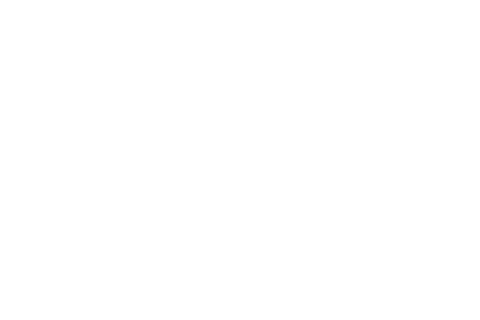

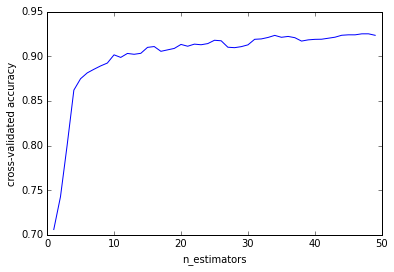

In [138]:
import matplotlib
%matplotlib nbagg
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(rf_range, rf_scores)
plt.xlabel('n_estimators')
plt.ylabel('cross-validated accuracy')

## Optimized Random Forest

In [139]:
from sklearn.ensemble import RandomForestRegressor
rfor = RandomForestRegressor(max_depth = 15)
rforfit = rfor.fit(X,y)
result14 = rforfit.score(X_test,y_test)
print "The AUC for the variables selected with logistic regression is:"
print round(result14, 4)
print "The time it takes to run is:"


The AUC for the variables selected with logistic regression is:
0.7408
The time it takes to run is:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [140]:
rfor_range = range(1, 50)
rfor_scores = []

for k in rfor_range:
    rfreg = RandomForestRegressor(n_estimators=k, random_state=42)
    rfa_fit = rfreg.fit(X,y)
    rfa_scores = rfa_fit.score(X_test, y_test)
    rfor_scores.append(rfa_scores.mean())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1

<IPython.core.display.Javascript object>


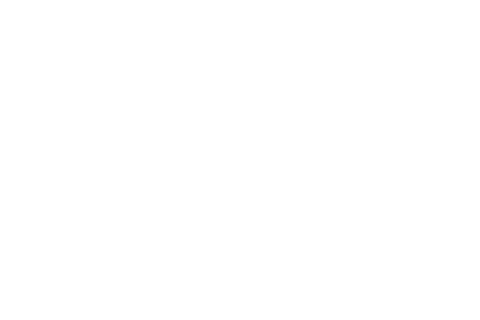

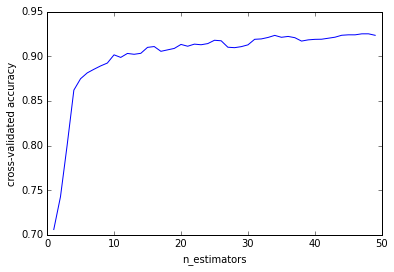

In [141]:
import matplotlib
%matplotlib nbagg
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(rfor_range, rfor_scores)
plt.xlabel('n_estimators')
plt.ylabel('cross-validated accuracy')

### Ridge Regression

In [142]:
from sklearn.linear_model import RidgeCV
np.mean(cross_val_score(RidgeCV(), X, y, scoring='mean_squared_error'))

-0.0011066443680588414

## Find Optimal K in KNN

In [143]:
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
x = range(1, 25)
knnoptim = []
for k in x:
    knno = KNeighborsRegressor(n_neighbors = k)
    kfit = knno.fit(X,y)
    scores = kfit.score(X_test, y_test)
    knnoptim.append(scores)

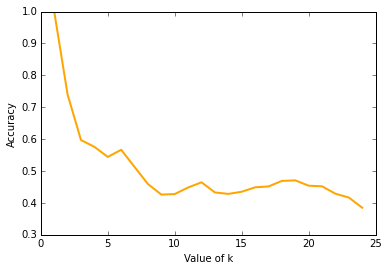

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x, knnoptim, color = 'orange', linewidth = 2)
plt.xlabel('Value of k')
plt.ylabel('Accuracy')

### K Nearest Neighbors rerun with N = 10, as determined from above accuracy testing

In [145]:
knn = KNeighborsRegressor(n_neighbors=3)
knnfit = knn.fit(X,y)
result =  knnfit.score(X_test, y_test)
print "The accuracy score selected with logistic regression is:"
print round(result, 4)
print "The time it took to run is:"

The accuracy score selected with logistic regression is:
0.5971
The time it took to run is:


### Find optimal max depth for Regression Decision tree

Here we iterate thru a set of ranges for maximum depth of a decision tree, to see what is the optimum depth

In [146]:
from sklearn.tree import DecisionTreeRegressor
deep = range(1, 100)
treeoptim = []
for i in deep:
    treee = DecisionTreeRegressor(random_state = 22, max_depth = i)
    treefit = treee.fit(X,y)
    treescore = treefit.score(X_test, y_test)
    treeoptim.append(treescore)

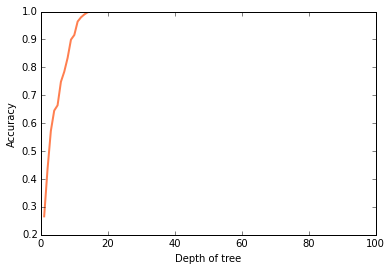

In [147]:
plt.plot(deep, treeoptim, color = 'coral', linewidth = 2)
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')

### Optimized Regression Decision Tree

Here we run a regression decision tree with a max depth of 20, as indicated from above accuracy testing

In [156]:
treee = DecisionTreeRegressor(random_state = 1, max_depth = 10)
treefit = treee.fit(X,y)
treescore = treefit.score(X_test, y_test)
print "The accuracy score for variables selected using a Regression Decision Tree is:"
treescore

The accuracy score for variables selected using a Regression Decision Tree is:


0.9161056329220636

## Ensemble methods - Bagging

In [150]:
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(max_samples = 640, random_state = 22)
bagfit = bag.fit(X, y)
result12 = bagfit.score(X_test, y_test)
print "The AUC for the variables selected with logistic regression is:"
print round(result12, 4)
print "The time it takes to run is:"

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: max_samples must be in (0, n_samples]

## Extremely Randomized Trees

In [151]:
from sklearn.ensemble import ExtraTreesRegressor
etree = ExtraTreesRegressor(random_state = 40, min_samples_split=1, bootstrap = True, max_depth = 3)
etreefit = etree.fit(X,y)
result16 = etreefit.score(X_test, y_test)
print "The AUC for the variables selected with logistic regression is:"
print round(result16, 4)
print "The time it takes to run is:"

The AUC for the variables selected with logistic regression is:
0.4149
The time it takes to run is:


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
